# NF Data (no degradation) Photo-z Code:

Natalia Stylianou (U. Leicester), with Alex Malz (GCCL@RUB) & Peter Hatfield (U. Oxford)

### Setup:
Prepare paths for local GPz module

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Coding')
import GPz

Imports

In [ ]:
import matplotlib
matplotlib.use('Agg')

from numpy import *
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pylab as pb
import numpy as np
from matplotlib.gridspec import GridSpec

### Run the NF data through GPz to estimate Photo-z Point Estimates and Posterior PDFs

In [ ]:
########### Model options ###############

method = 'VC'               # select method, options = GL, VL, GD, VD, GC and VC [required]
                            #
m = 50                      # number of basis functions to use [required]
                            #
joint = True                # jointly learn a prior linear mean function [default=true]
                            #
heteroscedastic = True      # learn a heteroscedastic noise process, set to false interested only in point estimates
                            #
csl_method = 'normal'       # cost-sensitive learning option: [default='normal']
                            #       'balanced':     to weigh rare samples more heavly during train
                            #       'normalized':   assigns an error cost for each sample = 1/(z+1)
                            #       'normal':       no weights assigned, all samples are equally important
                            #
binWidth = 0.1              # the width of the bin for 'balanced' cost-sensitive learning [default=range(z_spec)/100]

decorrelate = True          # preprocess the data using PCA [default=False]

########### Training options ###########

dataPath_samples = '/content/drive/MyDrive/Coding/samples.csv'    # path to the data set, has to be in the following format m_1,m_2,..,m_k,e_1,e_2,...,e_k,z_spec
                                        # where m_i is the i-th magnitude, e_i is its associated uncertainty and z_spec is the spectroscopic redshift
                                        # [required]


maxIter = 500                   # maximum number of iterations [default=200]
maxAttempts = 50              # maximum iterations to attempt if there is no progress on the validation set [default=infinity]
trainSplit = 0.2               # percentage of data to use for training
validSplit = 0.2               # percentage of data to use for validation
testSplit  = 0.6               # percentage of data to use for testing

########### Start of script ###########


# Load samples
# read data from file
data = loadtxt(open(dataPath_samples,"rb"),delimiter=",")


X_samples = data[:, 1:6]
n,d = X_samples.shape
Y_samples = data[:, 0].reshape(n, 1)

X_s = data[:, 2].reshape(n,1)

filters = d/2

# log the uncertainties of the magnitudes, any additional preprocessing should be placed here
X_samples[:, int(filters):] = log(X_samples[:, int(filters):])





# sample training, validation and testing sets from the data
training,validation,testing = GPz.sample(n,trainSplit,validSplit,testSplit)

# you can also select the size of each sample
# training,validation,testing = GPz.sample(n,10000,10000,10000)

# get the weights for cost-sensitive learning
omega = GPz.getOmega(Y_samples, method=csl_method)





# initialize the initial model
model_samples = GPz.GP(m,method=method,joint=joint,heteroscedastic=heteroscedastic,decorrelate=decorrelate)

# train the model
model_samples.train(X_samples.copy(), Y_samples.copy(), omega=omega, training=training, validation=validation, maxIter=maxIter, maxAttempts=maxAttempts)

########### NOTE ###########
# you can train the model gain, eve using different data, by executing:
# model.train(model,X,Y,options)

# use the model to generate predictions for the test set
mu_samples,sigma_samples,modelV_samples,noiseV_samples,_ = model_samples.predict(X_samples[testing,:].copy())




########### Display Results ###########

# compute metrics   (compared to samples - true redshifts)
rmse_samples = sqrt(GPz.metrics(Y_samples[testing],mu_samples,sigma_samples,lambda y,mu,sigma: (y-mu)**2))
mll_samples  = GPz.metrics(Y_samples[testing],mu_samples,sigma_samples,lambda y,mu,sigma: -0.5*(y-mu)**2/sigma-0.5*log(sigma)-0.5*log(2*pi))
fr15_samples = GPz.metrics(Y_samples[testing],mu_samples,sigma_samples,lambda y,mu,sigma: 100.0*(abs(y-mu)/(y+1.0)<0.15))
fr05_samples = GPz.metrics(Y_samples[testing],mu_samples,sigma_samples,lambda y,mu,sigma: 100.0*(abs(y-mu)/(y+1.0)<0.05))
bias_samples = GPz.metrics(Y_samples[testing],mu_samples,sigma_samples,lambda y,mu,sigma: y-mu)


# print metrics for the entire data
print(('{0:4s}\t\t\t{1:3s}\t\t\t{2:6s}\t\t\t{3:6s}\t\t\t{4:4s}'.format('RMSE', ' MLL', ' FR15', ' FR05', ' BIAS')))
print(('{0:1.7e}\t{1: 1.7e}\t{2: 1.7e}\t{3: 1.7e}\t{4: 1.7e}'.format(rmse_samples[-1], mll_samples[-1], fr15_samples[-1],fr05_samples[-1],bias_samples[-1])))


## Plots

Figure 1: plot of Photometric vs Spectrosopic Redshifts, coloured by Uncertainty:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


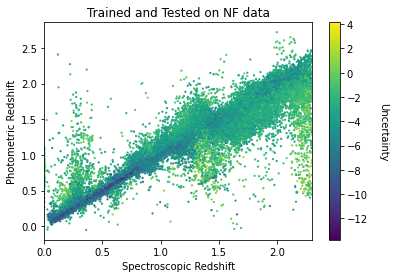

In [ ]:
f = plt.figure(1)
plt.scatter(Y_samples[testing,:],mu_samples,s=5, c=log(squeeze(sigma_samples)), edgecolor=['none'])

plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Photometric Redshift')
cbar = plt.colorbar()
cbar.set_label('Uncertainty', rotation=270, labelpad=20)
plt.title('Trained and Tested on NF data')
axes = plt.axes()
axes.set_xlim([0, 2.3])
pb.savefig("/content/drive/MyDrive/Coding/Results/samples_photoz_plots/NF_photoz_1.pdf", dpi=300, bbox_inches = "tight")

Figure 2: plot of Photometric vs Spectrosopic Redshifts, coloured by Density:

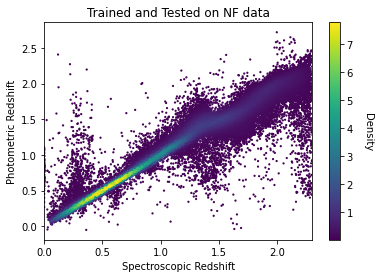

In [ ]:
f = plt.figure(2)
xy = hstack([Y_samples[testing,:], mu_samples]).T
z = gaussian_kde(xy)(xy)
axes = plt.axes()
axes.set_xlim([0, 2.3])
plt.scatter(Y_samples[testing,:],mu_samples, s=5, c=z, edgecolor=['none'])

plt.title('Trained and Tested on NF data')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Photometric Redshift')

cbar = plt.colorbar()
cbar.set_label('Density', rotation=270, labelpad=20)

pb.savefig("/content/drive/MyDrive/Coding/Results/samples_photoz_plots/NF_photoz_2.pdf", dpi=300, bbox_inches = "tight")

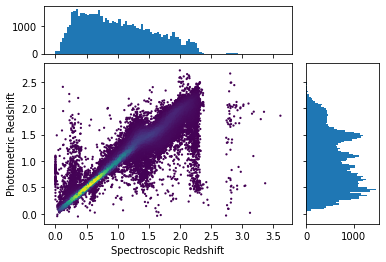

In [ ]:
# marginal histograms of spectroscopic redshifts and photometric redshift estimates

f = plt.figure(2.1)

gs = GridSpec(4,4)

ax_joint = f.add_subplot(gs[1:4,0:3])
ax_marg_x = f.add_subplot(gs[0,0:3])
ax_marg_y = f.add_subplot(gs[1:4,3])

xy = hstack([Y_samples[testing,:],mu_samples]).T
z = gaussian_kde(xy)(xy)

#ax_joint.scatter(Y_samples[testing,:], mu_samples, s=5, c=z, edgecolor=['none'])
im = ax_joint.scatter(Y_samples[testing,:], mu_samples, c=z, s=5, cmap=plt.cm.viridis, edgecolor=['none'])
#f.colorbar(im, ax=ax_joint)


ax_marg_x.hist(Y_samples[testing,:], bins=100)
ax_marg_y.hist(mu_samples,orientation="horizontal", bins=100)

# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Spectroscopic Redshift')
ax_joint.set_ylabel('Photometric Redshift')

# Set labels on marginals
#ax_marg_y.set_xlabel('Marginal x label')
#ax_marg_x.set_ylabel('Marginal y label')


#ax_joint.set_title('2 iterations - Trained on Samples and Tested on Samples', loc='center')
pb.savefig("/content/drive/MyDrive/Coding/Results/samples_photoz_plots/NF_photoz_2.1.pdf", dpi=300, bbox_inches = "tight")

### Plots of Point Estimate Evaluation Metrics 

Figure 3: plot of RMSE against the Percentage of the Data:

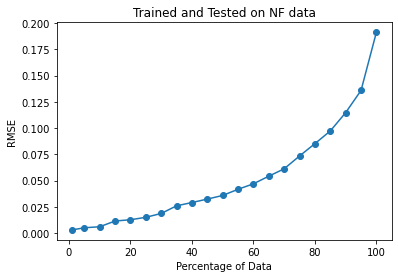

In [ ]:
# plot the change in metrics as functions of data percentage
x = array(list(range(0,20+1)))*5
x[0]=1

ind = x*len(rmse_samples) // 100

f = plt.figure(3)
plt.plot(x,rmse_samples[ind-1],'o-')
plt.xlabel('Percentage of Data')
plt.ylabel('RMSE')
plt.title('Trained and Tested on NF data')
pb.savefig("/content/drive/MyDrive/Coding/Results/samples_photoz_plots/NF_photoz_3_rmse.pdf", dpi=300, bbox_inches = "tight")

Figure 4: plot of MLL against the Percentage of the Data:

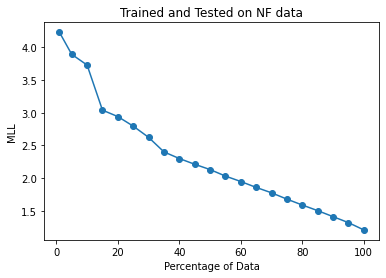

In [ ]:
f = plt.figure(4)
plt.plot(x,mll_samples[ind-1],'o-')
plt.xlabel('Percentage of Data')
plt.ylabel('MLL')
plt.title('Trained and Tested on NF data')
pb.savefig("/content/drive/MyDrive/Coding/Results/samples_photoz_plots/NF_photoz_4_mll.pdf", dpi=300, bbox_inches = "tight")

Figure 5: plot of FR15 against the Percentage of the Data:

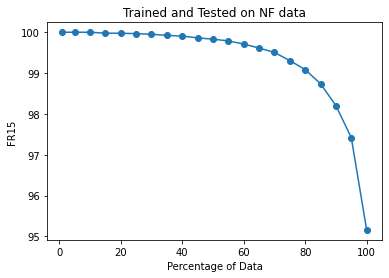

In [ ]:
f = plt.figure(5)
plt.plot(x,fr15_samples[ind-1],'o-')
plt.xlabel('Percentage of Data')
plt.ylabel('FR15')
plt.title('Trained and Tested on NF data')
pb.savefig("/content/drive/MyDrive/Coding/Results/samples_photoz_plots/NF_photoz_5_fr15.pdf", dpi=300, bbox_inches = "tight")

Figure 6: plot of FR05 against the Percentage of the Data:

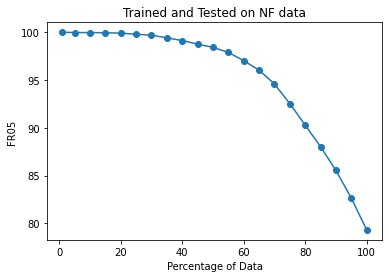

In [ ]:
f = plt.figure(6)
plt.plot(x,fr05_samples[ind-1],'o-')
plt.xlabel('Percentage of Data')
plt.ylabel('FR05')
plt.title('Trained and Tested on NF data')
pb.savefig("/content/drive/MyDrive/Coding/Results/samples_photoz_plots/NF_photoz_6_fr05.pdf", dpi=300, bbox_inches = "tight")

Figure 7: plot of BIAS against the Percentage of the Data:

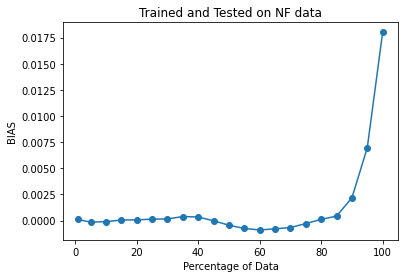

In [ ]:
f = plt.figure(7)
plt.plot(x,bias_samples[ind-1],'o-')
plt.xlabel('Percentage of Data')
plt.ylabel('BIAS')
plt.title('Trained and Tested on NF data')
pb.savefig("/content/drive/MyDrive/Coding/Results/samples_photoz_plots/NF_photoz_7_bias.pdf", dpi=300, bbox_inches = "tight")

### Plots of Evaluation Metrics against the Spectroscopic Redshift

Figure 8: plot of the Bias against the Spectroscopic Redshift:

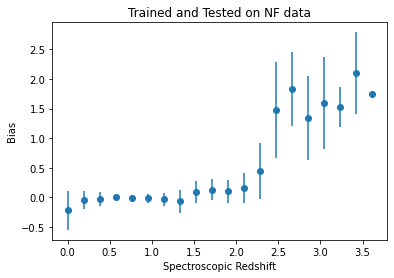

In [ ]:
# plot mean and standard deviation of different scores as functions of spectroscopic redshift using 20 bins
f = plt.figure(8)
centers,means,stds = GPz.bin(Y_samples[testing],Y_samples[testing]-mu_samples,20)
plt.errorbar(centers,means,stds,fmt='o')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Bias')
plt.title('Trained and Tested on NF data')
pb.savefig("/content/drive/MyDrive/Coding/Results/samples_photoz_plots/NF_photoz_8_bias.pdf", dpi=300, bbox_inches = "tight")

Figure 9: plot of the Model Uncertainty against the Spectroscopic Redshift:

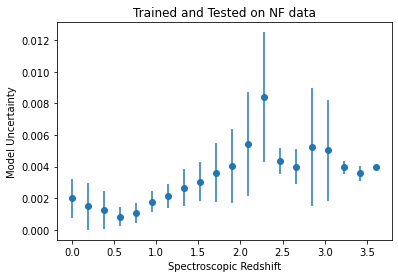

In [ ]:
f = plt.figure(9)
centers,means,stds = GPz.bin(Y_samples[testing],sqrt(modelV_samples),20)
plt.errorbar(centers,means,stds,fmt='o')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Model Uncertainty')
plt.title('Trained and Tested on NF data')
pb.savefig("/content/drive/MyDrive/Coding/Results/samples_photoz_plots/NF_photoz_9_modelV.pdf", dpi=300, bbox_inches = "tight")

Figure 10: plot of the Noise Uncertainty against the Spectroscopic Redshift:

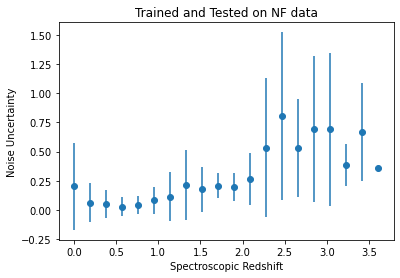

In [ ]:
f = plt.figure(10)
centers,means,stds = GPz.bin(Y_samples[testing],sqrt(noiseV_samples),20)
plt.errorbar(centers,means,stds,fmt='o')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Noise Uncertainty')
plt.title('Trained and Tested on NF data')
pb.savefig("/content/drive/MyDrive/Coding/Results/samples_photoz_plots/NF_photoz_10_noiseV.pdf", dpi=300, bbox_inches = "tight")

Figure 11: plot of the Bias against the R-Band Magnitude:

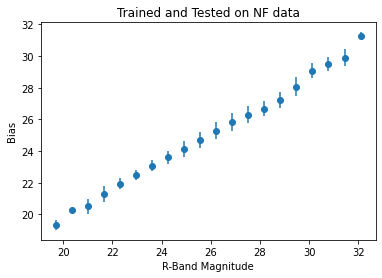

In [ ]:
# plot of bias as a function of magnitude 
f = plt.figure(11)
X_s = data[:, 2].reshape(n,1)
centers,means,stds = GPz.bin(X_s[testing,:], X_s[testing,:] - mu_samples, 20)
plt.errorbar(centers,means,stds,fmt='o')
plt.xlabel('R-Band Magnitude')
plt.ylabel('Bias')
plt.title('Trained and Tested on NF data')

pb.savefig("/content/drive/MyDrive/Coding/Results/samples_photoz_plots/NF_photoz_11_bias.pdf", dpi=300, bbox_inches = "tight")